<a href="https://colab.research.google.com/github/miguelamda/DL/blob/master/Ejercicios/Ejercicio2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio 3-a. Transfer learning de modelos convolucionales

El apartado a del ejercicio 3 es una continuación del ejercicio 2, donde deberás analizar la técnica de transfer learning sobre el dataset de mascarillas. Por tanto, necesitarás hacer uso de lo visto en la práctica 5.3.

![mask](https://github.com/miguelamda/DL/blob/master/Ejercicios/img/mask.jpg?raw=1)

## 1. Enunciado

Empleando el dataset de mascarillas del ejercicio 2, debes probar lo siguiente:
* Utilizar [**3 modelos pre-entrenados**](https://keras.io/api/applications/) para hacer transfer learning mediante extracción de características. Al menos uno de ellos debe de ser un modelo pensado para entornos de poca potencia computacional (pocos parámetros), como por ejemplo MobileNet o EfficientNet.
* Seleccionando el mejor modelo del punto anterior, realizar fine-tuning sobre algunas capas (la selección del número de capas es a tu elección). Probar al menos 2 combinaciones (por ejemplo, desbloqueando 2 y 7 capas...).
* Evaluar cuantitativamente cada combinación de modelos con el conjunto de validación/test del dataset original, así como con otro dataset distinto sobre detección de mascarillas (face mask detection), como por ejemplo https://www.kaggle.com/datasets/dipuiucse/facemaskdataset2022. Si el dataset es muy grande, como el propuesto, basta con tomar una pequeña muestra suficiente para sacar estadísticas. Usar distintas métricas: accuracy, precision, recall, F1-score, etc.
* Evaluar cualitativamente el rendimiento del mejor modelo obtenido con imágenes obtenidas por tu webcam, o bien con imágenes de rostros con/sin mascarillas obtenidas de Internet.

## 2. Entrega

La entrega de este ejercicio se realiza a través de la tarea creada para tal efecto en Enseñanza Virtual. Tienes que entregar un notebook, y el HTML generado a partir de él, cuyas celdas estén ya evaluadas.

La estructura del notebook debe contener los siguientes apartados:

0. Cabecera: nombre y apellidos.
1. Preparación de los datos para ser usados en Keras.
2. Modelos y configuraciones creados en Keras basados en 3 modelos pre-entrenados (un sub-apartado para cada uno, explicando de forma razonada, con tus palabras, por qué se elige el modelo y qué clasificador se añade).
3. Entrenamiento y evaluación de cada modelo creado (un sub-apartado para cada uno). Análisis de resultados.
4. Selección del mejor modelo, y fine-tuning de dos combinaciones de capas (con pocas y muchas capas). Análisis de resultados.
5. Evaluación de los modelos sobre conjunto de test, y sobre otro dataset para face mask detection. Evaluación también sobre imágenes de webcam/Internet.
6. Bibliografía utilizada (enlaces web, material de clase, libros, etc.).

### 2.1. Nota importante
-----
**HONESTIDAD ACADÉMICA Y COPIAS: un trabajo práctico es un examen, por lo que
debe realizarse de manera individual. La discusión y el intercambio de
información de carácter general con los compañeros se permite (e incluso se
recomienda), pero NO AL NIVEL DE CÓDIGO. Igualmente el remitir código de
terceros, OBTENIDO A TRAVÉS DE LA RED o cualquier otro medio, se considerará
plagio.**

**Cualquier plagio o compartición de código que se detecte significará
automáticamente la calificación de CERO EN LA ASIGNATURA para TODOS los
alumnos involucrados. Por tanto a estos alumnos NO se les conservará, para
futuras convocatorias, ninguna nota que hubiesen obtenido hasta el momento.
SIN PERJUICIO DE OTRAS MEDIDAS DE CARÁCTER DISCIPLINARIO QUE SE PUDIERAN
TOMAR.**

-----

# <center> Cabecera </center>

# Alfonso Alarcón Tamayo

# <center> Preparación de los datos </center>

Para la carga de de datos subiremos el conjunto de dataset como un zip a google drive y lo descomprimiremos desde ahí

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Copiamos el dataset y lo decomprimimos
!cp /content/drive/MyDrive/mask_ds.zip .
!unzip -q mask_ds.zip

In [5]:
# Desmontamos
drive.flush_and_unmount()

# <center> Modelos y configuraciones creados en Keras basados en 3 modelos pre-entrenados </center>


Como ya hemos visto en las prácticas, cuando se trabaja con un dataset pequeño, es muy aconsejable usar redes ya entrenadas, para reutilizar ese aprendizaje obtenido en ese dataset mas grande en el nuestro, aún habiendo sido entrenado con imagenes muy distintas.

Para los problemas la elección de un modelo es importante ya que una transferencia de aprendizaje adecuada acelera el proceso de aprendizaje y ayuda a nuestro modelo a que generalice

# Modelo 1

Para este primer modelo he optado por usar VGG16, este es un modelo utilizado para clasificación de imágenes (como es nuestro caso).

He realizado algunas pruebas con imágenes sueltas y la tasa de acierto con usuarios con mascarilla es bastante alta(aunque detecta diferentes tipos de máscara, entiende bien que la persona de la foto lleva algún tipo de máscara en la cara)

El clasificador que he decidido usar en los 3 modelos ha sido la primera opción vista en la práctica (aplicar la base convolucional sobre el dataset y esos datos aplicarlos a un clasificador independiente)

he optado por este ya que es el que menos recursos consume de los dos ya que mi ordenador le lleva bastante tiempo procesar la información

In [6]:
from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions

modeloVGG16 = VGG16()

553467096/553467096 [==============================] - 5s 0us/step


58889256/58889256 [==============================] - 0s 0us/step


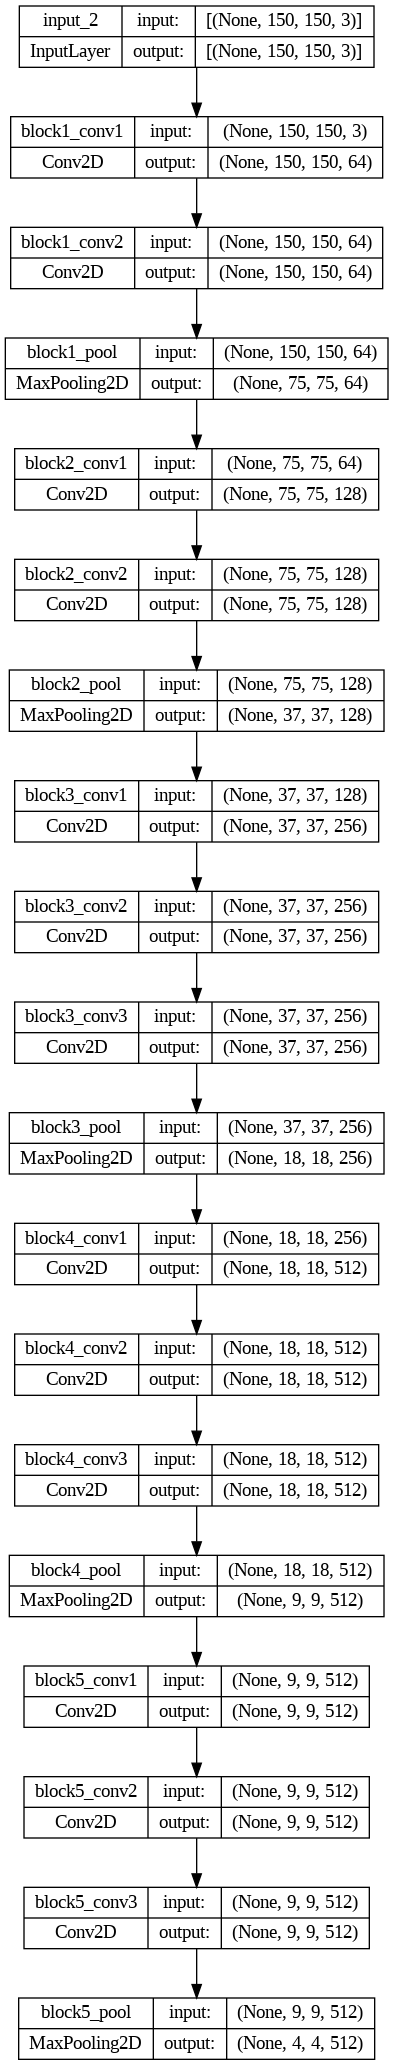

In [7]:
from tensorflow.keras.utils import plot_model

conv_base_VGG16 = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

plot_model(conv_base_VGG16, to_file='conv_base_plot.png', show_shapes=True, show_layer_names=True)

Aqui lo que vamos a hacer es transfer learning de los modelos preentrenamos que hemos elegido, es decir, vamos a usar la red ya preentrenada sobre muchos datos para extraer las características relevantes. He usado el ejemplo dado en la práctica 5.3

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'mask_ds'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base_VGG16.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # sin el break estaria cargando indefinidamente
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

In [9]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features=np.reshape(test_features, (1000, 4 * 4 * 512))

Aquí lo que he hecho ha sido aplanar las características para poder usarlas en una capa densa en mi modelo

# Modelo 2

Para este segundo modelo he optado por usar VGG19, al igual que con el modelo anterior he probado con varias imágenes del conjunto y detecta bien las mascarillas (le da un alto porcentaje a la probailidad de que tengan una máscara).

El modelo VGG19 es un modelo entrenado para clasificación y he estado investigando por internet y fue muy usado (y se sigue usando) durante la pandemia para detectar si la gente usaba mascarilla,por lo que lo he usado este modelo preentrenado como segunda opción

In [10]:
from tensorflow.keras.applications.vgg19 import VGG19
modeloVGG19 = VGG19()

574710816/574710816 [==============================] - 7s 0us/step


80134624/80134624 [==============================] - 0s 0us/step


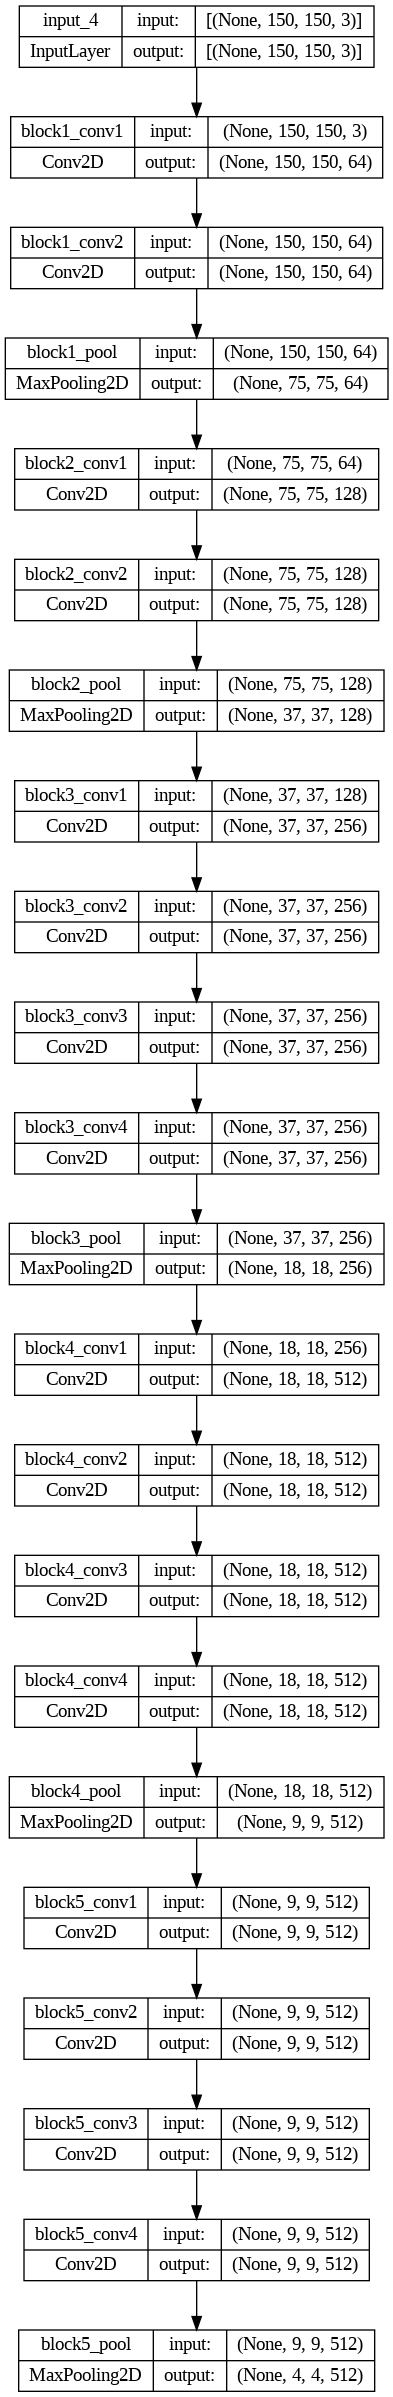

In [11]:
conv_base_VGG19 = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

plot_model(conv_base_VGG19, to_file='conv_base_plot2.png', show_shapes=True, show_layer_names=True)

In [12]:
def extract_features_VGG19(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base_VGG19.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # sin el break estaria infinitamente cargando valores
            break
    return features, labels

train_features_VGG19, train_labels_VGG19 = extract_features_VGG19(train_dir, 2000)
validation_features_VGG19, validation_labels_VGG19 = extract_features_VGG19(validation_dir, 1000)
test_features_VGG19, test_labels_VGG19 = extract_features_VGG19(test_dir, 1000)

Found 4433 images belonging to 2 classes.
1/1 [==============================] - 7s 7s/step
Found 2267 images belonging to 2 classes.
1/1 [==============================] - 7s 7s/step
Found 1960 images belonging to 2 classes.
1/1 [==============================] - 5s 5s/step


In [13]:

train_features_VGG19 = np.reshape(train_features_VGG19, (2000, 4 * 4 * 512))
validation_features_VGG19 = np.reshape(validation_features_VGG19, (1000, 4 * 4 * 512))
test_features_VGG19 = np.reshape(test_features_VGG19, (1000, 4 * 4 * 512))

# Modelo 3

Para el tercer y último modelo he utilizado EfficientNetB0, este modelo lo he usado porque en teoría nos piden usar un modelo que requiera de poca potencia(menos parámetros que los otros).

En este modelo podemos ver que el número de capas es mucho mayor a los dos anteriores, en lo que se basa este modelo es en encontrar un conjunto óptimo que minimice los recursos utilizados mientras maximiza el rendimiento

In [14]:
from tensorflow.keras.applications import EfficientNetB0
modelEfficientNetB0 = EfficientNetB0()

21834768/21834768 [==============================] - 0s 0us/step


16705208/16705208 [==============================] - 0s 0us/step


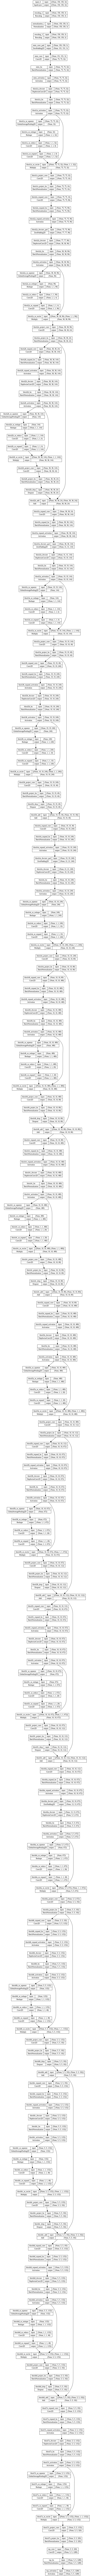

In [15]:
conv_base_Eff = EfficientNetB0(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

plot_model(conv_base_Eff, to_file='conv_base_plot3.png', show_shapes=True, show_layer_names=True)

In [16]:
def extract_features_Eff(directory, sample_count):
    features = np.zeros(shape=(sample_count, 5,5 , 1280))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base_Eff.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features_Eff, train_labels_Eff = extract_features_Eff(train_dir, 2000)
validation_features_Eff, validation_labels_Eff = extract_features_Eff(validation_dir, 1000)
test_features_Eff, test_labels_Eff = extract_features_Eff(test_dir, 1000)

Found 4433 images belonging to 2 classes.
1/1 [==============================] - 0s 500ms/step
Found 2267 images belonging to 2 classes.
1/1 [==============================] - 1s 501ms/step
Found 1960 images belonging to 2 classes.
1/1 [==============================] - 1s 520ms/step


In [17]:
train_features_Eff = np.reshape(train_features_Eff, (2000, 5 *5 * 1280))
validation_features_Eff = np.reshape(validation_features_Eff, (1000, 5 * 5 * 1280))
test_features_Eff = np.reshape(test_features_Eff, (1000, 5 * 5 * 1280))

# <center> Entrenamiento y evaluación de cada modelo creado (un sub-apartado para cada uno). Análisis de resultados. </center>


# Modelo 1

En este primer modelo podemos ver que tenemos un acierto muy bueno tanto en el conjunto de entrenamiento como en el de validación (prácticamente al 100% en entrenamiento y cerca del 98 en validación).Se puede observar que conforme avanzas las epocas, se sobreajusta un poco.

He añadido dos capas con 512 y 256 neuronas con activación relu con el objetivo de que al añadir más neuronas, al disponer de un conjunto de datos no excesivamente grande quizás esta configuración ha provocado el sobreajuste que se puede ver en la gráfica

In [18]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-3),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 5s 45ms/step - loss: 0.6469 - acc: 0.8150 - val_loss: 0.3163 - val_acc: 0.8690
Epoch 2/30
100/100 [==============================] - 5s 47ms/step - loss: 0.1863 - acc: 0.9335 - val_loss: 0.3722 - val_acc: 0.8670
Epoch 3/30
100/100 [==============================] - 5s 51ms/step - loss: 0.1383 - acc: 0.9555 - val_loss: 0.1552 - val_acc: 0.9330
Epoch 4/30
100/100 [==============================] - 4s 41ms/step - loss: 0.1211 - acc: 0.9595 - val_loss: 0.2237 - val_acc: 0.9230
Epoch 5/30
100/100 [==============================] - 5s 45ms/step - loss: 0.1054 - acc: 0.9685 - val_loss: 0.0774 - val_acc: 0.9670
Epoch 6/30
100/100 [==============================] - 6s 55ms/step - loss: 0.0851 - acc: 0.9735 - val_loss: 0.0995 - val_acc: 0.9660
Epoch 7/30
100/100 [==============================] - 4s 42ms/step - loss: 0.0700 - acc: 0.9780 - val_loss: 0.1901 - val_acc: 0.9470
Epoch 8/30
100/100 [==============================] - 5s 51ms/step - 

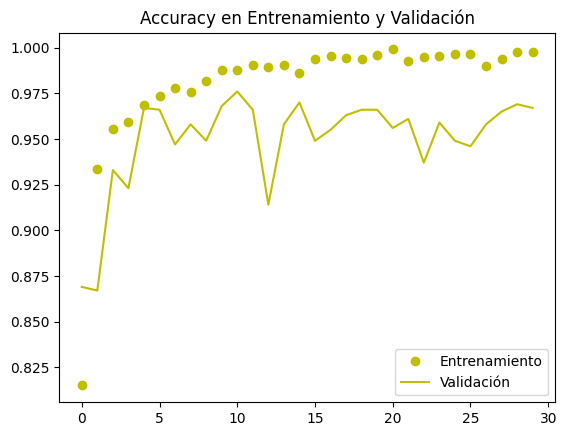

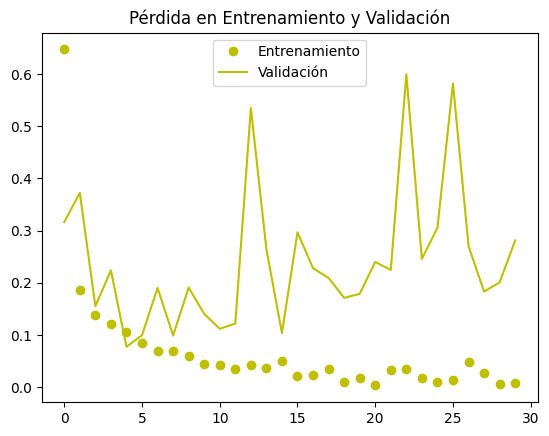

In [19]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

ent_acc = history.history['acc']
val_acc = history.history['val_acc']
ent_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(ent_acc))

plt.plot(epochs, ent_acc, 'yo', label='Entrenamiento')
plt.plot(epochs, val_acc, 'y', label='Validación')
plt.title('Accuracy en Entrenamiento y Validación')
plt.legend()

plt.figure()

plt.plot(epochs, ent_loss, 'yo', label='Entrenamiento')
plt.plot(epochs, val_loss, 'y', label='Validación')
plt.title('Pérdida en Entrenamiento y Validación')
plt.legend()

plt.show()

# Modelo 2

Este segundo modelo es usando VGG19, en este podemos ver que desde las primeras epocas de adapta mejor y que aunque disminuye minimamente el rendimiento (alrededor de un 1%) tiene un poco menos de sobreajuste y es mas suave la curva.

La pérdida tambien en ambos casos es menor y esta la curva mas suavizada(en el anterior es más irregular)

Podemos ver aqui comparado con el primero que con un número menor de neuronas y capas, el modelo en validación desde el principio es mas regular.

In [20]:
from keras import models
from keras import layers
from keras import optimizers

model2 = models.Sequential()
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history2 = model2.fit(train_features_VGG19, train_labels_VGG19,
                      epochs=30,
                      batch_size=50,
                      validation_data=(validation_features_VGG19, validation_labels_VGG19))


Epoch 1/30
40/40 [==============================] - 2s 33ms/step - loss: 0.5162 - acc: 0.7385 - val_loss: 0.4637 - val_acc: 0.7550
Epoch 2/30
40/40 [==============================] - 1s 36ms/step - loss: 0.3435 - acc: 0.8635 - val_loss: 0.3828 - val_acc: 0.8000
Epoch 3/30
40/40 [==============================] - 2s 42ms/step - loss: 0.2679 - acc: 0.8960 - val_loss: 0.3104 - val_acc: 0.8580
Epoch 4/30
40/40 [==============================] - 2s 40ms/step - loss: 0.2239 - acc: 0.9210 - val_loss: 0.2449 - val_acc: 0.8960
Epoch 5/30
40/40 [==============================] - 1s 31ms/step - loss: 0.1967 - acc: 0.9270 - val_loss: 0.2243 - val_acc: 0.9080
Epoch 6/30
40/40 [==============================] - 1s 28ms/step - loss: 0.1683 - acc: 0.9345 - val_loss: 0.2262 - val_acc: 0.9020
Epoch 7/30
40/40 [==============================] - 1s 27ms/step - loss: 0.1516 - acc: 0.9460 - val_loss: 0.2258 - val_acc: 0.8980
Epoch 8/30
40/40 [==============================] - 1s 27ms/step - loss: 0.1476 - a

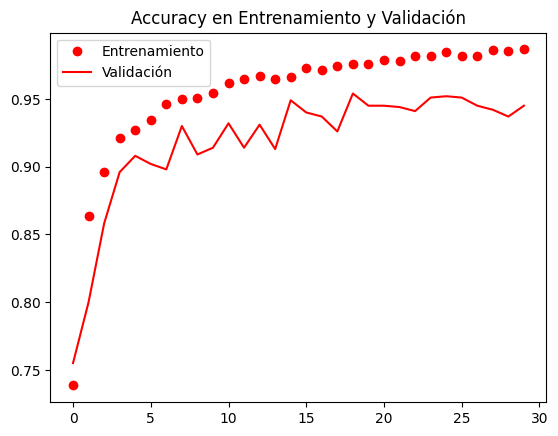

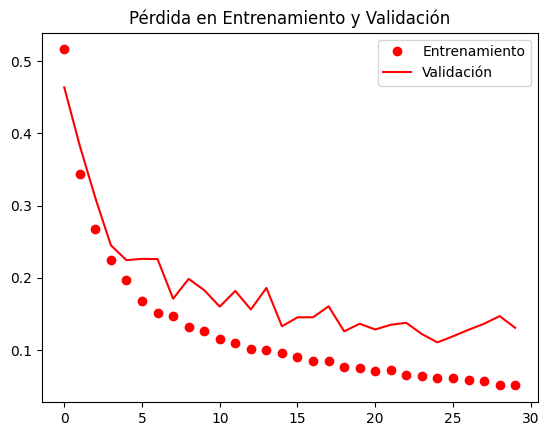

In [21]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

ent_acc = history2.history['acc']
val_acc = history2.history['val_acc']
ent_loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(ent_acc))

plt.plot(epochs, ent_acc, 'ro', label='Entrenamiento')
plt.plot(epochs, val_acc, 'r', label='Validación')
plt.title('Accuracy en Entrenamiento y Validación')
plt.legend()

plt.figure()

plt.plot(epochs, ent_loss, 'ro', label='Entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Validación')
plt.title('Pérdida en Entrenamiento y Validación')
plt.legend()

plt.show()

# Modelo 3

Para este tercer omodelo estamos usando EfficientNetB0, como ya he comentado antes es un modelo especializado en tratar con pocos elementos, en este caso he añadido un par de capas más que el ejemplo anterior.

Podemos ver en la gráfica que el modelo esta "anclado" no mejora con el paso de las épocas y el rendimiento no es bueno (65% y 50% respectivamente en entrenamiento y validación)



In [22]:
from keras import models
from keras import layers
from keras import optimizers

model3 = models.Sequential()
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history3 = model3.fit(train_features_Eff, train_labels_Eff,
                    epochs=20,
                    batch_size=40,
                    validation_data=(validation_features_Eff, validation_labels_Eff))

Epoch 1/20
50/50 [==============================] - 8s 150ms/step - loss: 1.7258 - acc: 0.6060 - val_loss: 0.6953 - val_acc: 0.5080
Epoch 2/20
50/50 [==============================] - 6s 121ms/step - loss: 0.6672 - acc: 0.6340 - val_loss: 0.7045 - val_acc: 0.5080
Epoch 3/20
50/50 [==============================] - 9s 174ms/step - loss: 0.6598 - acc: 0.6340 - val_loss: 0.7167 - val_acc: 0.5080
Epoch 4/20
50/50 [==============================] - 7s 139ms/step - loss: 0.6575 - acc: 0.6340 - val_loss: 0.7219 - val_acc: 0.5080
Epoch 5/20
50/50 [==============================] - 6s 129ms/step - loss: 0.6576 - acc: 0.6340 - val_loss: 0.7266 - val_acc: 0.5080
Epoch 6/20
50/50 [==============================] - 5s 105ms/step - loss: 0.6679 - acc: 0.6320 - val_loss: 0.7248 - val_acc: 0.5080
Epoch 7/20
50/50 [==============================] - 9s 188ms/step - loss: 0.6571 - acc: 0.6340 - val_loss: 0.7234 - val_acc: 0.5080
Epoch 8/20
50/50 [==============================] - 6s 114ms/step - loss: 0.

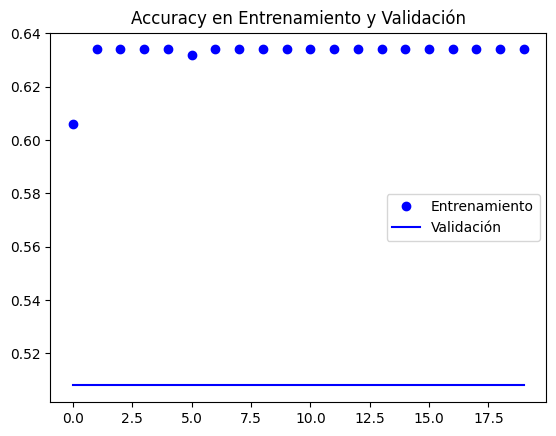

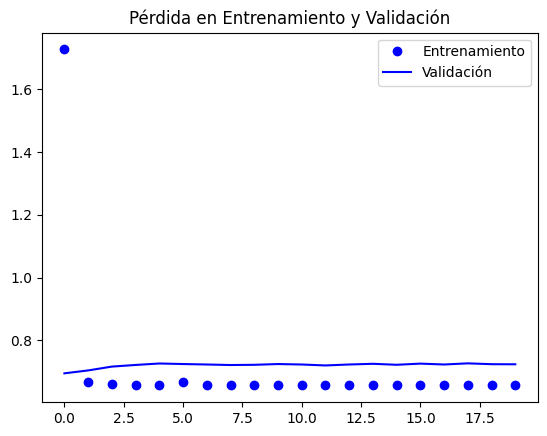

In [23]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

ent_acc = history3.history['acc']
val_acc = history3.history['val_acc']
ent_loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(ent_acc))

plt.plot(epochs, ent_acc, 'bo', label='Entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Validación')
plt.title('Accuracy en Entrenamiento y Validación')
plt.legend()

plt.figure()

plt.plot(epochs, ent_loss, 'bo', label='Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Validación')
plt.title('Pérdida en Entrenamiento y Validación')
plt.legend()

plt.show()

# <center> Selección del mejor modelo, y fine-tuning de dos combinaciones de capas (con pocas y muchas capas). Análisis de resultados. </center>


El mejor modelo que hemos encontrado ha sido el segundo (el que hemos usado VGG19) obteniendo alrededor de un 97% de acierto.

Vamos a aplicarle fine-tunning con muchas y pocas capas.

Aplicar fine-tunning consiste en descongelar algunas capas de la base preentrenada (VGG19) en nuestro caso y entrenar conjuntamente las descongeladas con las añadidas

In [24]:
conv_base_VGG19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

vamos a descongelar y entrenar desde la base block5 y ver como afecta al rendimiento

In [25]:
conv_base_VGG19.trainable = True

train = False
# recorre las capas y a partir de la block5_conv1 descongela 
for layer in conv_base_VGG19.layers:
    if layer.name == 'block5_conv1':
        train = True
    if train:
        layer.trainable = True
    else:
        layer.trainable = False

In [26]:
model2.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history2 = model2.fit(train_features_VGG19, train_labels_VGG19,
                      epochs=30,
                      batch_size=50,
                      validation_data=(validation_features_VGG19, validation_labels_VGG19))

Epoch 1/30
40/40 [==============================] - 2s 32ms/step - loss: 0.0496 - acc: 0.9870 - val_loss: 0.1195 - val_acc: 0.9500
Epoch 2/30
40/40 [==============================] - 1s 27ms/step - loss: 0.0475 - acc: 0.9875 - val_loss: 0.1067 - val_acc: 0.9520
Epoch 3/30
40/40 [==============================] - 1s 27ms/step - loss: 0.0433 - acc: 0.9900 - val_loss: 0.1007 - val_acc: 0.9560
Epoch 4/30
40/40 [==============================] - 2s 38ms/step - loss: 0.0432 - acc: 0.9900 - val_loss: 0.1144 - val_acc: 0.9520
Epoch 5/30
40/40 [==============================] - 2s 39ms/step - loss: 0.0426 - acc: 0.9895 - val_loss: 0.1099 - val_acc: 0.9510
Epoch 6/30
40/40 [==============================] - 2s 42ms/step - loss: 0.0415 - acc: 0.9890 - val_loss: 0.1016 - val_acc: 0.9530
Epoch 7/30
40/40 [==============================] - 1s 27ms/step - loss: 0.0388 - acc: 0.9915 - val_loss: 0.1171 - val_acc: 0.9480
Epoch 8/30
40/40 [==============================] - 1s 31ms/step - loss: 0.0394 - a

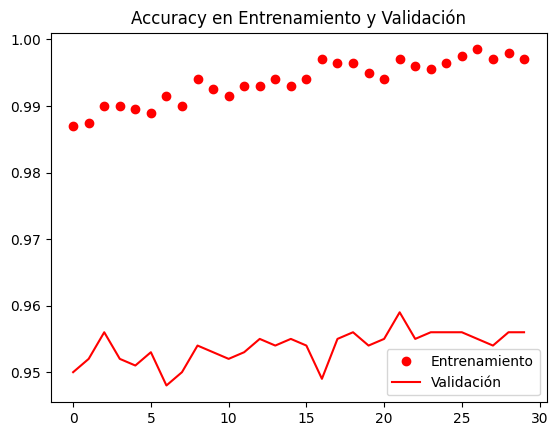

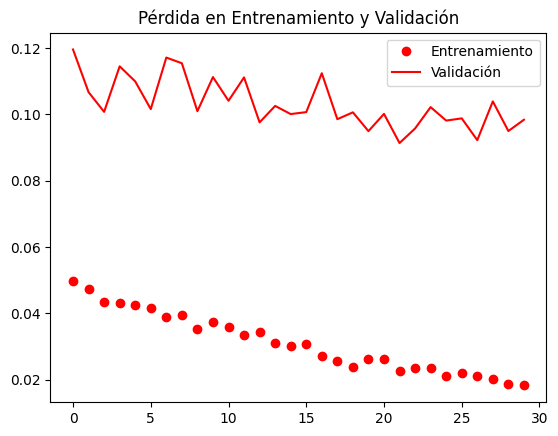

In [27]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

ent_acc = history2.history['acc']
val_acc = history2.history['val_acc']
ent_loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(ent_acc))

plt.plot(epochs, ent_acc, 'ro', label='Entrenamiento')
plt.plot(epochs, val_acc, 'r', label='Validación')
plt.title('Accuracy en Entrenamiento y Validación')
plt.legend()

plt.figure()

plt.plot(epochs, ent_loss, 'ro', label='Entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Validación')
plt.title('Pérdida en Entrenamiento y Validación')
plt.legend()


En este primer caso podemos ver (aunque la gráfica no sea muy intuitiva) que obtenemos una leve mejora en el rendimiento y menos pérdida:
Entrenamiento 98->99.8%
Validación 95->95.6

Aquí hemos descongelado solo algunas de las últimas capas y las hemos entrenado con el resto del modelo que hemos creado,hemos obtenido una leve mejora puede ser debido a quede esta manera estamos haciendo que se adapte mejor a nuestro problema especificamente



In [28]:
conv_base_VGG19.trainable = True

train = False
for layer in conv_base_VGG19.layers:
    if layer.name == 'block4_conv1':
        train = True
    if train:
        layer.trainable = True
    else:
        layer.trainable = False

In [29]:
model2.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),  # Corrige lr a learning_rate
              loss='binary_crossentropy',
              metrics=['acc'])

history2 = model2.fit(train_features_VGG19, train_labels_VGG19,
                      epochs=30,
                      batch_size=50,
                      validation_data=(validation_features_VGG19, validation_labels_VGG19))

Epoch 1/30
40/40 [==============================] - 2s 32ms/step - loss: 0.0201 - acc: 0.9960 - val_loss: 0.0929 - val_acc: 0.9570
Epoch 2/30
40/40 [==============================] - 1s 28ms/step - loss: 0.0161 - acc: 0.9980 - val_loss: 0.0982 - val_acc: 0.9570
Epoch 3/30
40/40 [==============================] - 1s 27ms/step - loss: 0.0172 - acc: 0.9970 - val_loss: 0.1003 - val_acc: 0.9550
Epoch 4/30
40/40 [==============================] - 1s 27ms/step - loss: 0.0164 - acc: 0.9985 - val_loss: 0.1083 - val_acc: 0.9480
Epoch 5/30
40/40 [==============================] - 1s 31ms/step - loss: 0.0161 - acc: 0.9985 - val_loss: 0.0896 - val_acc: 0.9560
Epoch 6/30
40/40 [==============================] - 2s 58ms/step - loss: 0.0166 - acc: 0.9975 - val_loss: 0.1062 - val_acc: 0.9500
Epoch 7/30
40/40 [==============================] - 3s 63ms/step - loss: 0.0162 - acc: 0.9990 - val_loss: 0.1098 - val_acc: 0.9490
Epoch 8/30
40/40 [==============================] - 3s 68ms/step - loss: 0.0157 - a

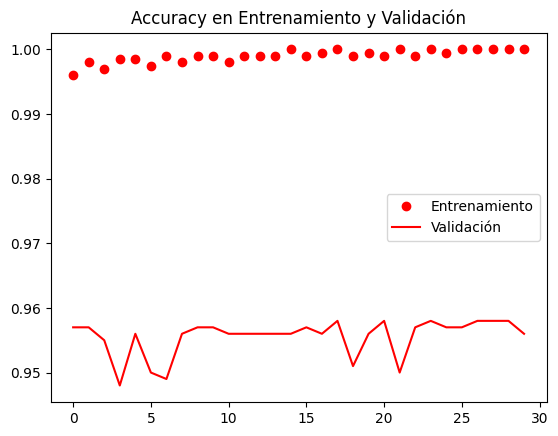

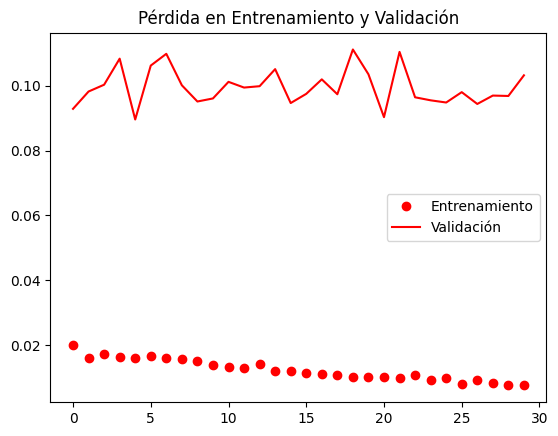

In [30]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

ent_acc = history2.history['acc']
val_acc = history2.history['val_acc']
ent_loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(ent_acc))

plt.plot(epochs, ent_acc, 'ro', label='Entrenamiento')
plt.plot(epochs, val_acc, 'r', label='Validación')
plt.title('Accuracy en Entrenamiento y Validación')
plt.legend()

plt.figure()

plt.plot(epochs, ent_loss, 'ro', label='Entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Validación')
plt.title('Pérdida en Entrenamiento y Validación')
plt.legend()


Podemos suavizar un poco la curva como con el metodo smooth_curve visto en clase en la práctica 5

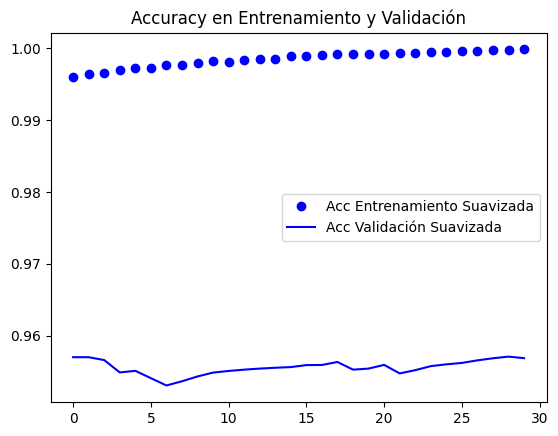

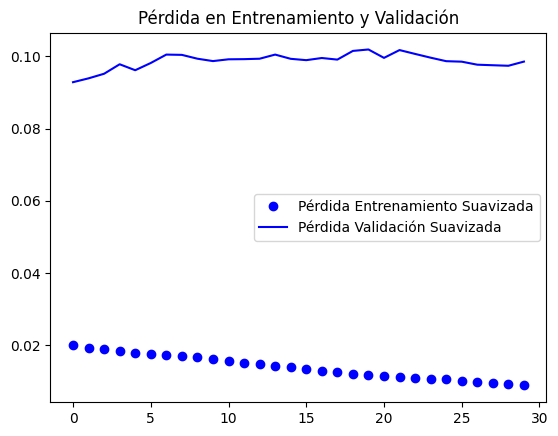

In [31]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(ent_acc), 'bo', label='Acc Entrenamiento Suavizada')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Acc Validación Suavizada')
plt.title('Accuracy en Entrenamiento y Validación')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(ent_loss), 'bo', label='Pérdida Entrenamiento Suavizada')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Pérdida Validación Suavizada')
plt.title('Pérdida en Entrenamiento y Validación')
plt.legend()

plt.show()

En este segundo caso noto que el modelo se sobreajusta un poco más, ya que en el entrenamiento alcanza el 100% mientrás que en validación empeora minimamente.
Quizás al descongelar y entrenar tantas capas he provocado que el modelo se adapte demasiado a mi modelo y provoque ese sobreajuste, o quizás al no ser el modelo muy grande con tantas capas provoca también el sobreajuste.

# <center>Evaluación de los modelos sobre conjunto de test, y sobre otro dataset para face mask detection </center>


Vamos a comprobar varios valores en concreto aaccuracy,precision,recall y f1 asi que voy a comentar brevemente que nos da esa información.

* Accuracy : es como su nombre indica el número de aciertos
* precision/perdida: cuanto se equivoca el modelo con respecto a su valor
* recall: Se calcula como el número de verdaderos positivos dividido por la suma de verdaderos positivos y falsos negativos, si es cercado a 1 indica que el modelo es bueno clasificando
* f1:Calcula la precisión pero usando de manera conjunta la precisión y el recall

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

predictions = model.predict(test_features)

# Convertimos en etiquetas binarias
rounded_predictions = np.round(predictions)

# F1-score
f1 = f1_score(test_labels, rounded_predictions)
recall = recall_score(test_labels, rounded_predictions)


# Evaluar el modelo
test_loss, test_acc = model.evaluate(test_features, test_labels)
print('Test accuracy:', test_acc)
print('test_loss:', test_loss)
print('Test F1-score:', f1)
print('Recall:', recall)



32/32 [==============================] - 1s 36ms/step - loss: 0.2742 - acc: 0.9640
Test accuracy: 0.9639999866485596
test_loss: 0.2742430567741394
Test F1-score: 0.96709323583181
Recall: 0.9742173112338858


Podemos ver que para el modelo 1 hemos obtenido una precisión del 96.4% teniendo en cuenta que en validación obtuvimos un 96.7 % podemos decir que es un buen rendimiento para el test, ya que es próximo al rendimiento obtenido en los otros casos. Como añadido podemos ver que la perdida es baja (indicativo de un buen modelo).
Para los valores de f1 y recall al ser próximos a 1 nos indica que el modelo es bueno clasificando


In [37]:
predictions2 = model2.predict(test_features_VGG19)

rounded_predictions = np.round(predictions2)

# F1-score
f1 = f1_score(test_labels, rounded_predictions)
recall = recall_score(test_labels, rounded_predictions)


# Evaluar el modelo
test_loss, test_acc = model2.evaluate(test_features_VGG19, test_labels_VGG19)
print('Test accuracy:', test_acc)
print('test_loss:', test_loss)
print('Test F1-score:', f1)
print('Recall:', recall)

32/32 [==============================] - 1s 11ms/step - loss: 0.0900 - acc: 0.9630
Test accuracy: 0.9629999995231628
test_loss: 0.09000647068023682
Test F1-score: 0.5459558823529412
Recall: 0.5469613259668509


Para nuestro segundo modelo obtenemos un rendimiento similar, la precisión alrededor de un 96%, aunque en este caso la pérdida es menor,la pérdida es una medida de cuánto se desvían las predicciones del modelo de las etiquetas reales en el conjunto de pruebas. Aunque en este caso las métricas del F1 y el recall son más bajas

In [38]:
predictions3 = model3.predict(test_features_Eff)


rounded_predictions = np.round(predictions3)

# Calcular el F1-score
f1 = f1_score(test_labels, rounded_predictions)
recall = recall_score(test_labels, rounded_predictions)


# Evaluar el modelo
test_loss, test_acc = model3.evaluate(test_features_Eff, test_labels_Eff)
print('Test accuracy:', test_acc)
print('test_loss:', test_loss)
print('Test F1-score:', f1)
print('Recall:', recall)

32/32 [==============================] - 1s 18ms/step - loss: 0.7197 - acc: 0.5160
Test accuracy: 0.515999972820282
test_loss: 0.7197336554527283
Test F1-score: 0.7038237200259235
Recall: 1.0


#### Nuevo conjunto

Ahora para el conjunto nuevo haremos lo mismo que al principio, de drive obtendremos las imagenes de un subconjunto que he obtenido(el del enlace de la entrega que recomiendan usar) y he reducido su tamaño  manteniendo la proporción ya que era muy grande

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
# Copiamos el dataset y lo decomprimimos
!cp /content/drive/MyDrive/Face_Mask_Dataset.zip .
!unzip -q Face_Mask_Dataset.zip

In [40]:
# Desmontamos
drive.flush_and_unmount()

In [41]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'Face_Mask_Dataset'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features2(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base_VGG16.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

test_features, test_labels = extract_features2(test_dir, 1000)

Found 2073 images belonging to 2 classes.
1/1 [==============================] - 4s 4s/step


In [43]:

test_features=np.reshape(test_features, (1000, 4 * 4 * 512))

Ahora que hemos extraido las características vamos a comprobar las métricas anteriores para este nuevo conjunto

Prueba con el modelo 1: VGG16

In [47]:
predictions = model.predict(test_features)

# Convertimos las probabilidades en etiquetas binarias
rounded_predictions = np.round(predictions)

f1 = f1_score(test_labels, rounded_predictions)
recall = recall_score(test_labels, rounded_predictions)

# Evaluar el modelo original
test_loss, test_acc = model.evaluate(test_features, test_labels)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)
print('Test F1-score:', f1)
print('Recall:', recall)


32/32 [==============================] - 0s 11ms/step - loss: 1.0188 - acc: 0.9150
Test accuracy: 0.9150000214576721
Test loss: 1.0188205242156982
Test F1-score: 0.9177153920619554
Recall: 0.9978947368421053


Para este caso vemos que aunque la pérdida sea algo mayor obtenemos un buen rendimiento (91.5%). Además los valores de f1 y recall son bastante mejores que en el caso anterior, en general, se nos muestra que para este nuevo conjunto de mascarillas el modelo generado da un buen resultado

Prueba con VGG19

In [52]:
predictions = model.predict(test_features)

# Convertir las probabilidades en etiquetas binarias
rounded_predictions = np.round(predictions)

f1 = f1_score(test_labels, rounded_predictions)
recall = recall_score(test_labels, rounded_predictions)

# Evaluar el modelo original
test_loss, test_acc = model2.evaluate(test_features, test_labels)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)
print('Test F1-score:', f1)
print('Recall:', recall)


32/32 [==============================] - 1s 14ms/step - loss: 0.3543 - acc: 0.8520
Test accuracy: 0.8519999980926514
Test loss: 0.35433080792427063
Test F1-score: 0.9177153920619554
Recall: 0.9978947368421053


Para este segundo modelo el rendimiento ha decaido hasta un 85%, aunque tiene un f1 y recall , indicando que cuando clasifica bien una imagen como positiva(mascarilla) esta bastante seguro de la fiabilidad de esta

# <center> Bibliografía utilizada (enlaces web, material de clase, libros, etc.). </center>

https://colab.research.google.com/github/miguelamda/DL/blob/master/5.%20Redes%20Convolucionales/Practica5.3.%20CNN%20Preentrenadas.ipynb#scrollTo=3iMLhsATxRWx

https://www.v7labs.com/blog/f1-score-guide#:~:text=for%20Machine%20Learning-,What%20is%20F1%20score%3F,prediction%20across%20the%20entire%20dataset.

https://medium.com/@dhirajchaudhari481/vgg16-19-best-performing-convnet-models-in-computer-vision-eeca3fa34788

https://www.kaggle.com/code/greynolan/face-mask-detection-vgg19/notebook

https://d2l.ai/chapter_computer-vision/fine-tuning.html